# Intro to Phylogenetics

In [5]:
from phylogenetics.phylogenetics import PhylogeneticsProject
import os
import Bio
import subprocess

from Bio.Blast.NCBIWWW import qblast
from Bio.Blast import NCBIXML
from Bio.Align.Applications import MuscleCommandline
import phylopandas as phy
import pandas as pd

### Blast, reverse blast, and alignment code to build an alignment for phylogenetics API

In [6]:
def blast(project_directory, seed_sequences, blast_type="blastp", database="nr", hits=100):
    
    """
    NCBI blast pipeline. 
    seed_sequences: fasta file of initial sequences to use for blasting
    """
    
    # provide seed sequence(s)
    
    seeds = phy.read_fasta(seed_sequences)
    seed = list(seeds.sequence.values)

    # query ncbi blast using seed sequences
    # default is protein-protein blast using non-redundant database
    
    raw_results = qblast(blast_type, database, seed, hitlist_size=hits)
    
    with open("blast_results.xml", "w") as f:
        f.write(raw_results.read())
        f.close()
    
    # parse raw blast xml output into pandas dataframe
   
    df = phy.read_blast_xml("blast_results.xml")
    phy.seqio.write.to_fasta(df, id_col="accession", filename="blast_results.fasta")
    
    return df

In [7]:
def clustering(infile, outfile):
    
    """
    Cluster sequences to remove redundant/similar ones using cd-hit.
    """

    cml = ['cd-hit', "-i", infile, "-o", outfile]
    output = subprocess.run(cml)
    
    return output

In [8]:
def align(infile, outfile):
    
    """
    align sequences using muscle.
    """

    cml = MuscleCommandline(input=infile, out=outfile)
    cml_args = str(cml).split()
    output = subprocess.run(args=cml_args)
    
    return output

### Blast for MD2 sequences

In [5]:
# Run NCBI blast, saving results out to fasta file
# this will take a few minutes...

blast_results = blast(project_directory='md2', seed_sequences="md2_seed_sequence.txt")
print(len(blast_results))
blast_results.head()

100


accession                                            hit_def  \
0     NP_056179  lymphocyte antigen 96 isoform 1 precursor [Hom...   
1  NP_001123946  lymphocyte antigen 96 precursor [Pan troglodyt...   
2  XP_002819229  lymphocyte antigen 96 [Pongo abelii] >gb|PNJ54...   
3      AKI71615                LY96, partial [synthetic construct]   
4  NP_001266676  lymphocyte antigen 96 precursor [Gorilla goril...   

                hit_id                                              title  \
0     ref|NP_056179.4|  ref|NP_056179.4| lymphocyte antigen 96 isoform...   
1  ref|NP_001123946.1|  ref|NP_001123946.1| lymphocyte antigen 96 prec...   
2  ref|XP_002819229.1|  ref|XP_002819229.1| lymphocyte antigen 96 [Pon...   
3       gb|AKI71615.1|  gb|AKI71615.1| LY96, partial [synthetic constr...   
4  ref|NP_001266676.1|  ref|NP_001266676.1| lymphocyte antigen 96 prec...   

   length        e_value                                           sequence  
0     160  4.810340e-115  MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...  
1     160  7.900930e-114  MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...  
2     160  2.098480e-113  MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...  
3     160  3.476680e-113  MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYAYCDKMQYPISI...  
4     160  3.966100e-113  MLPFLFFSTLFSSTFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...

### cluster sequences to remove redundancy

In [6]:
clustering("blast_results.fasta", "clustered_blast_results.fasta")

CompletedProcess(args=['cd-hit', '-i', 'blast_results.fasta', '-o', 'clustered_blast_results.fasta'], returncode=0)

### reverse blast sequences for quality control

In [ ]:
# in the works



### align sequences (using muscle)

In [8]:
align("clustered_blast_results.fasta", "alignment.fasta")

CompletedProcess(args=['muscle', '-in', 'clustered_blast_results.fasta', '-out', 'alignment.fasta'], returncode=0)

### pipe alignment into phylogenetics API

In [9]:
# Add an alignment

project = PhylogeneticsProject('md2', overwrite=True)

project.read_data(path='alignment.fasta', schema='fasta')

# Run a tree
project.compute_tree()

In [10]:
# Run a reconstruction
project.compute_reconstruction()

In [17]:
# dataframe of aligned sequences, tree, and ancestors
project.data.head()

uid   description          id       label  \
0  IKC3S56nuK  XP_004842102  IKC3S56nuK  IKC3S56nuK   
1  4Tx7IAOfLU  XP_004637614  4Tx7IAOfLU  4Tx7IAOfLU   
2  tWY8Fx452o  XP_014709236  tWY8Fx452o  tWY8Fx452o   
3  9lDJky5sEu  XP_004679848  9lDJky5sEu  9lDJky5sEu   
4  RG3Ww8nZrx  XP_016071489  RG3Ww8nZrx  RG3Ww8nZrx   

                                            sequence  type parent  \
0  MLPFMLFSTLFSPIFTEPEEPLWICSSSDANISYTYCDNKKFPISI...  leaf     12   
1  MLPLMLFSTLFSPIFTEPKDHHWICNSSDASISYTYCDDMKFPISV...  leaf     12   
2  MFSFMLFFTLFSSIFPEPEELRWICNSSDMSIWYTYCDNMKSPISI...  leaf     16   
3  MFPLMLFSTLFSSIFTEPGEKHWICNSSDASIWYSYCDNMKYPISI...  leaf     28   
4  MFPLMLFSMLFSSTCTEPREPHWICNSSDLTFWYTYCDHMEYPILI...  leaf     29   

  branch_length    length  distance reconstruct_label ml_sequence  \
0          None   0.15093  0.622059        IKC3S56nuK        None   
1          None  0.169398  0.640527        4Tx7IAOfLU        None   
2          None  0.263066  0.561345        tWY8Fx452o        None   
3          None  0.261811  0.574858        9lDJky5sEu        None   
4          None  0.226245  0.567623        RG3Ww8nZrx        None   

  ml_posterior alt_sequence alt_posterior  
0         None         None          None  
1         None         None          None  
2         None         None          None  
3         None         None          None  
4         None         None          None

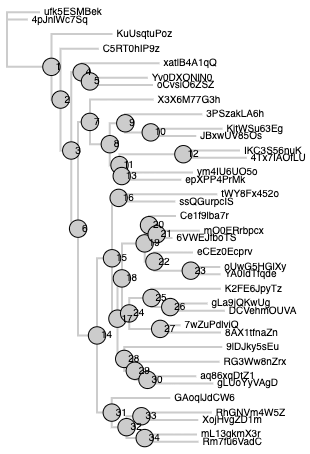

In [25]:
# Visualize tree and ancestors using phylovega

from phylovega import TreeChart

# Construct Vega Specification
chart = TreeChart.from_phylopandas(
    project.data,
    height_scale=300,

    # Node attributes
    node_size=300,
    node_color="#ccc",

    # Leaf attributes
    leaf_labels="id",

    # Edge attributes
    edge_width=2,
    edge_color="#000",
)

chart